In [1]:
import os, sys; sys.path.append(os.path.abspath('../'))

In [2]:
# Crawl the data directory
import os

data_dir = r'..\data\baseline'

data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')]
# loop over the files

import scipy.io

All_network_X = []
All_network_y = []

for f in data_files[:10]:
    data = scipy.io.loadmat(f)
    test_x = data['test_x']
    test_out = data['test_out']

    All_network_X.append(test_x)
    All_network_y.append(test_out)

import numpy as np

All_network_X = np.array(All_network_X)
All_network_y = np.array(All_network_y)

In [8]:
y_last_50_avg = All_network_y[:, :, :, -50:]
y_last_50_avg.shape
y_last_50_avg = np.average(y_last_50_avg, axis=3)
y_last_50_avg.shape
y_last_50_avg = y_last_50_avg.reshape(y_last_50_avg.shape[0], -1)
y_last_50_avg.shape

# for every value in y_last_50_avg, if it is greater than 0, set it to 1, else set it to -1
y_last_50_avg[y_last_50_avg > 0] = 1
y_last_50_avg[y_last_50_avg < 0] = -1

x_nuron_avg = np.average(All_network_X, axis=3)
x_nuron_avg.shape
x_nuron_avg = x_nuron_avg.reshape(10, 4*50, 300)
x_nuron_avg.shape
print(x_nuron_avg.shape, y_last_50_avg.shape)

(10, 200, 300) (10, 200)


In [14]:
import itertools
from inspector.dataset import SyntheticNetworks
from matplotlib import pyplot as plt
from netrep.metrics.stochastic import GaussianStochasticMetric

In [1]:
# create 10 synthetic networks
network_generator = SyntheticNetworks()
networks_X, networks_y = network_generator.generate(networks=10)

networks_X = np.array(networks_X)
networks_y = np.array(networks_y)

NameError: name 'SyntheticNetworks' is not defined

In [23]:
networks_X.shape, networks_y.shape

((10, 500, 2), (10, 500))

In [44]:
x_nuron_avg = x_nuron_avg[:, :, :2]
y_last_50_avg = y_last_50_avg[:, :]

print(x_nuron_avg.shape, y_last_50_avg.shape)

(10, 200, 2) (10, 200)


In [45]:
# X1 = networks_X[0]
# y1 = networks_y[0]

# X2 = networks_X[1]
# y2 = networks_y[1]

# X3 = networks_X[2]
# y3 = networks_y[2]

X1 = x_nuron_avg[0]
y1 = y_last_50_avg[0]

X2 = x_nuron_avg[1]
y2 = y_last_50_avg[1]

X3 = x_nuron_avg[2]
y3 = y_last_50_avg[2]

In [46]:
X1.shape

(200, 2)

In [47]:
def get_means_and_covs(
    X,
    y
):
    """Helper method that computes class-conditional means and covariances."""
    
    classes = np.unique(y)
    K = len(classes)
    means = np.stack([np.mean(X[y==k], 0) for k in classes], 0) # Meaning: compute the mean of each class
    covs = np.stack([np.cov(X[y==k].T) for k in classes], 0) # Meaning: compute the covariance of each class
    return means, covs

# compute the class-conditional means and covariances for each network
means_x1, covs_x1 = get_means_and_covs(X1, y1)
means_x2, covs_x2 = get_means_and_covs(X2, y2)
means_x3, covs_x3 = get_means_and_covs(X3, y3)

print("(means_x1.shape, covs_x2.shape)", (means_x1.shape, covs_x1.shape))

# compile into mu and sigma dicts for easier processing
means = (means_x1, means_x2, means_x3)
covs = (covs_x1, covs_x2, covs_x3)

(means_x1.shape, covs_x2.shape) ((2, 2), (2, 2, 2))


In [48]:
# check NaN in array
np.isnan(covs_x3).any()

False

In [49]:
distmats_w2 = dict()

# compute Wasserstein ground metric for alpha=(0, 1, 2)
for alpha in (0, 1, 2):
    distmat_w2 = np.zeros((3, 3))
    metric = GaussianStochasticMetric(alpha)
    for i,j in itertools.combinations(range(3), 2): # Meaning: compute the distance between each pair of networks
        
        # the fit method expects a list [means, covs]
        Xi = (means[i], covs[i]) # Meaning: Xi is a tuple of the means and covariances of network i
        Xj = (means[j], covs[j]) # Meaning: Xj is a tuple of the means and covariances of network j


        metric.fit(Xi, Xj)
        distmat_w2[i,j] = metric.score(Xi, Xj)

        # My score printing code
        print(f"alpha {alpha}: Network {i+1} vs Network {j+1} -> score {distmat_w2[i,j]}") # Meaning: print the pair of networks

    # dist matrix is symmetric
    distmat_w2 += distmat_w2.T
    distmats_w2[alpha] = distmat_w2

alpha 0: Network 1 vs Network 2 -> score 0.009619173307805385
alpha 0: Network 1 vs Network 3 -> score 0.022817069798710395
alpha 0: Network 2 vs Network 3 -> score 0.029319219314232748
alpha 1: Network 1 vs Network 2 -> score 2.069198310075465
alpha 1: Network 1 vs Network 3 -> score 1.5671642000084665
alpha 1: Network 2 vs Network 3 -> score 0.5025799962098607
alpha 2: Network 1 vs Network 2 -> score 2.9262400954512597
alpha 2: Network 1 vs Network 3 -> score 2.21618378403931
alpha 2: Network 2 vs Network 3 -> score 0.7100608668059486


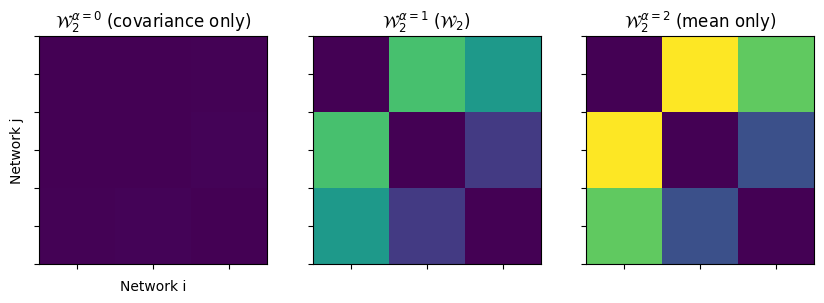

In [50]:
# plot the distmats
titles = [r"$\mathcal{W}_2^{\alpha=0}$" " (covariance only)",
          r"$\mathcal{W}_2^{\alpha=1}$" " ($\mathcal{W}_2$)",
          r"$\mathcal{W}_2^{\alpha=2}$" " (mean only)"]

# All heatmaps share same colorbar limits
_VMAX = max([distmats_w2[k].max() for k in distmats_w2])
_VMIN = min([distmats_w2[k].min() for k in distmats_w2])

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex="all", sharey="all")

for i, a in enumerate(distmats_w2.keys()):
    im = ax[i].imshow(distmats_w2[a], vmin=_VMIN, vmax=_VMAX)
    ax[i].set(title=titles[i])
ax[0].set(xticklabels=[], yticklabels=[], xlabel="Network i", ylabel="Network j");
# plt.colorbar()

# So it works when there are 2 Features

## Checking with different number of features:

Works with n_features 2, 3, 50, 80, 90, 99, 100:102, 100:199,

0 to 100 does not work, 

In [138]:
y_last_50_avg = All_network_y[:, :, :, -50:]
y_last_50_avg.shape
y_last_50_avg = np.average(y_last_50_avg, axis=3)
y_last_50_avg.shape
y_last_50_avg = y_last_50_avg.reshape(y_last_50_avg.shape[0], -1)
y_last_50_avg.shape

# for every value in y_last_50_avg, if it is greater than 0, set it to 1, else set it to -1
y_last_50_avg[y_last_50_avg > 0] = 1
y_last_50_avg[y_last_50_avg < 0] = -1

x_nuron_avg = np.average(All_network_X, axis=3)
x_nuron_avg.shape
x_nuron_avg = x_nuron_avg.reshape(10, 4*50, 300)
print(x_nuron_avg.shape, y_last_50_avg.shape)

(10, 200, 300) (10, 200)


In [211]:
x_nuron_avg_t = x_nuron_avg[:, :, 100:300]
y_last_50_avg = y_last_50_avg[:, :]

In [212]:
# check if there is any NaN in the array
print(np.isnan(x_nuron_avg_t).any())
# check if there is any infinte in the array
print(np.asarray_chkfinite(x_nuron_avg_t).any())
# Check if there is infinite in the array
print(np.isinf(x_nuron_avg_t).any())

False
True
False


In [213]:
np.asarray_chkfinite(x_nuron_avg_t).shape

(10, 200, 200)

In [214]:
print(x_nuron_avg_t.shape, y_last_50_avg.shape)
# X1 = networks_X[0]
# y1 = networks_y[0]

# X2 = networks_X[1]
# y2 = networks_y[1]

# X3 = networks_X[2]
# y3 = networks_y[2]

X1 = x_nuron_avg_t[0]
y1 = y_last_50_avg[0]

X2 = x_nuron_avg_t[1]
y2 = y_last_50_avg[1]

X3 = x_nuron_avg_t[2]
y3 = y_last_50_avg[2]

X4 = x_nuron_avg_t[3]
y4 = y_last_50_avg[3]

X5 = x_nuron_avg_t[4]
y5 = y_last_50_avg[4]

X6 = x_nuron_avg_t[5]
y6 = y_last_50_avg[5]

X7 = x_nuron_avg_t[6]
y7 = y_last_50_avg[6]

X8 = x_nuron_avg_t[7]
y8 = y_last_50_avg[7]

X9 = x_nuron_avg_t[8]
y9 = y_last_50_avg[8]

X10 = x_nuron_avg_t[9]
y10 = y_last_50_avg[9]

X1.shape
def get_means_and_covs(
    X,
    y
):
    """Helper method that computes class-conditional means and covariances."""
    
    classes = np.unique(y)
    K = len(classes)
    means = np.stack([np.mean(X[y==k], 0) for k in classes], 0) # Meaning: compute the mean of each class
    covs = np.stack([np.cov(X[y==k].T) for k in classes], 0) # Meaning: compute the covariance of each class
    return means, covs

# compute the class-conditional means and covariances for each network
means_x1, covs_x1 = get_means_and_covs(X1, y1)
means_x2, covs_x2 = get_means_and_covs(X2, y2)
means_x3, covs_x3 = get_means_and_covs(X3, y3)
means_x4, covs_x4 = get_means_and_covs(X4, y4)
means_x5, covs_x5 = get_means_and_covs(X5, y5)
means_x6, covs_x6 = get_means_and_covs(X6, y6)
means_x7, covs_x7 = get_means_and_covs(X7, y7)
means_x8, covs_x8 = get_means_and_covs(X8, y8)
means_x9, covs_x9 = get_means_and_covs(X9, y9)
means_x10, covs_x10 = get_means_and_covs(X10, y10)

print("(means_x1.shape, covs_x2.shape)", (means_x1.shape, covs_x1.shape))

# compile into mu and sigma dicts for easier processing
# means = (means_x1, means_x2, means_x3)
# covs = (covs_x1, covs_x2, covs_x3)
means = (means_x1, means_x2, means_x3, means_x4, means_x5, means_x6, means_x7, means_x8, means_x9, means_x10)
covs = (covs_x1, covs_x2, covs_x3, covs_x4, covs_x5, covs_x6, covs_x7, covs_x8, covs_x9, covs_x10)

(10, 200, 200) (10, 200)
(means_x1.shape, covs_x2.shape) ((2, 200), (2, 200, 200))


In [215]:
covs_x1[1].shape

(200, 200)

In [216]:
covs_x2[1]

array([[ 0.37320143,  0.37880127,  0.38062736, ..., -0.06744272,
        -0.06799666, -0.07035216],
       [ 0.37880127,  0.38616045,  0.38873877, ..., -0.06868164,
        -0.06944515, -0.07213072],
       [ 0.38062736,  0.38873877,  0.39276786, ..., -0.07150454,
        -0.07229596, -0.07545966],
       ...,
       [-0.06744272, -0.06868164, -0.07150454, ...,  0.13262921,
         0.12997184,  0.1278809 ],
       [-0.06799666, -0.06944515, -0.07229596, ...,  0.12997184,
         0.12913885,  0.1276435 ],
       [-0.07035216, -0.07213072, -0.07545966, ...,  0.1278809 ,
         0.1276435 ,  0.12761412]])

In [217]:
a, b = np.linalg.eigh(covs_x2[1])
print(np.linalg.eigh(covs_x2[1]))

np.sqrt(a)

(array([-1.74726219e-15, -1.19141813e-15, -1.07935338e-15, -7.34045245e-16,
       -6.82311445e-16, -6.20499179e-16, -5.93778065e-16, -5.81740938e-16,
       -5.56247503e-16, -5.13744073e-16, -4.87467238e-16, -4.58716116e-16,
       -4.29927851e-16, -4.27191607e-16, -3.98208091e-16, -3.81175644e-16,
       -3.77720048e-16, -3.62791943e-16, -3.37203427e-16, -3.20091765e-16,
       -3.15053695e-16, -3.05158594e-16, -2.90183917e-16, -2.85207070e-16,
       -2.53574796e-16, -2.53399368e-16, -2.43736331e-16, -2.43012154e-16,
       -2.21419637e-16, -2.01861742e-16, -1.97850548e-16, -1.96991357e-16,
       -1.86070787e-16, -1.74693952e-16, -1.64658684e-16, -1.58451688e-16,
       -1.51660063e-16, -1.33890439e-16, -1.31795444e-16, -1.11131053e-16,
       -9.73058993e-17, -9.44851978e-17, -9.18011769e-17, -8.77657113e-17,
       -7.68840126e-17, -6.53134874e-17, -6.24195709e-17, -4.86583053e-17,
       -3.06566592e-17, -2.57906015e-17, -2.05130297e-17,  3.91864303e-18,
        4.34537574e-18, 

C:\Users\monac\AppData\Local\Temp\ipykernel_16932\2896328637.py:4: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(a)


array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan, 1.97955627e-09,
       2.08455648e-09, 3.03322300e-09, 3.56262569e-09, 5.08426587e-09,
      

In [209]:
# compute Wasserstein ground metric for alpha=(0, 1, 2)
for alpha in (0, 1, 2):
    distmat_w2 = np.zeros((3, 3))
    metric = GaussianStochasticMetric(alpha)
    for i,j in itertools.combinations(range(10), 2): # Meaning: compute the distance between each pair of networks
        
        # the fit method expects a list [means, covs]
        Xi = (means[i], covs[i]) # Meaning: Xi is a tuple of the means and covariances of network i
        Xj = (means[j], covs[j]) # Meaning: Xj is a tuple of the means and covariances of network j


        metric.fit(Xi, Xj)
        distmat_w2[i,j] = metric.score(Xi, Xj)

        # My score printing code
        print(f"alpha {alpha}: Network {i+1} vs Network {j+1} -> score {distmat_w2[i,j]}") # Meaning: print the pair of networks

    # dist matrix is symmetric
    distmat_w2 += distmat_w2.T
    distmats_w2[alpha] = distmat_w2

ValueError: array must not contain infs or NaNs

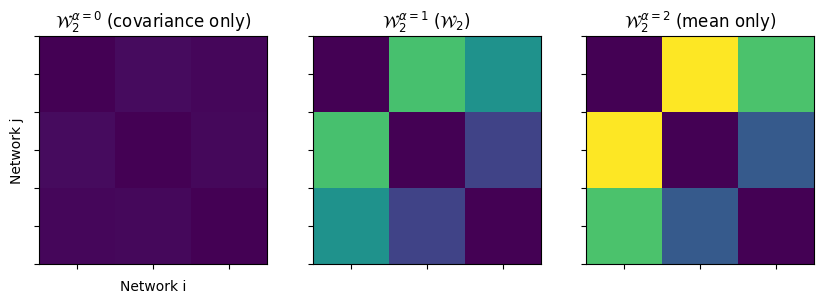

In [56]:
# plot the distmats
titles = [r"$\mathcal{W}_2^{\alpha=0}$" " (covariance only)",
          r"$\mathcal{W}_2^{\alpha=1}$" " ($\mathcal{W}_2$)",
          r"$\mathcal{W}_2^{\alpha=2}$" " (mean only)"]

# All heatmaps share same colorbar limits
_VMAX = max([distmats_w2[k].max() for k in distmats_w2])
_VMIN = min([distmats_w2[k].min() for k in distmats_w2])

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex="all", sharey="all")

for i, a in enumerate(distmats_w2.keys()):
    im = ax[i].imshow(distmats_w2[a], vmin=_VMIN, vmax=_VMAX)
    ax[i].set(title=titles[i])
ax[0].set(xticklabels=[], yticklabels=[], xlabel="Network i", ylabel="Network j");
# plt.colorbar()